In [9]:
!pip install umap

In [10]:

import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

import math
import seaborn as sns
import umap
from PIL import Image
from scipy import misc
from os.path import isfile, join
from scipy import misc
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical


from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

In [11]:
from google.colab import drive

# Try mounting with force_remount=True to refresh credentials
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
image_dir="/content/drive/MyDrive/brain_tumor_dataset"

In [13]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [14]:
import os

# Specify the main directory - make sure this is a new directory, not an existing zip file
augmented_data_path = '/content/drive/MyDrive/brain_tumor_dataset'

# Specify the subdirectories
yes_dir = 'yes'
no_dir = 'no'

# Create the main directory if it doesn't exist
os.makedirs(augmented_data_path, exist_ok=True)

# Create the subdirectories if they don't exist
os.makedirs(os.path.join(augmented_data_path, yes_dir), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, no_dir), exist_ok=True)

# ... rest of your code ...

3. Data Preprocessing

In [15]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [16]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [17]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

Number of examples is: 2315
X shape is: (2315, 224, 224, 3)
y shape is: (2315, 1)


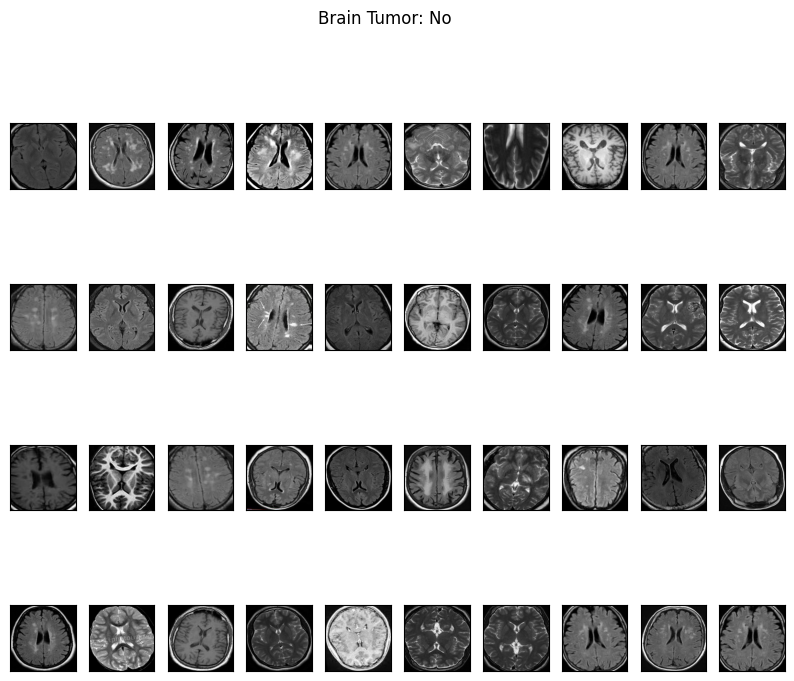

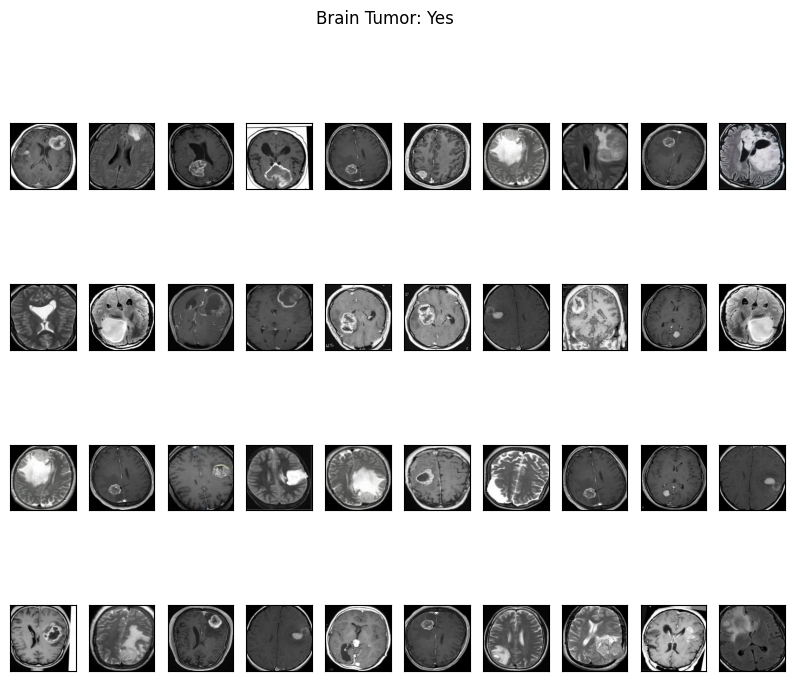

In [18]:
# Define the list of directories containing your images
dir_list = ['/content/drive/MyDrive/brain_tumor_dataset/yes',
             '/content/drive/MyDrive/brain_tumor_dataset/no']

# Define the desired image size
image_size = (224, 224)  # Example size, adjust as needed

# Now you can call the load_data function
X, y = load_data(dir_list, image_size)

# And plot sample images
plot_sample_images(X, y)

4. Data Splitting


In [19]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
# Verify that X and y are not empty before splitting
print("Shape of X:", X.shape)  # Assuming X is a NumPy array
print("Shape of y:", y.shape)  # Assuming y is a NumPy array

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

Shape of X: (2315, 224, 224, 3)
Shape of y: (2315, 1)


In [21]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1620
number of validation examples = 348
number of test examples = 347


5. First CNN Model ¶


In [22]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)

    X = Flatten()(X)
    X = Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.5)(X)  # Use tf.keras.layers.Dropout instead of Dropout

    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_input, outputs=X)

    return model


In [23]:
IMG_SHAPE = (224, 224, 3)  # Update IMG_SHAPE to match actual input data dimensions
model = build_model(IMG_SHAPE)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 228, 228, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 222, 222, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         692,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,345 (2.66 MB)

 Trainable params: 697,281 (2.66 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.5372 - loss: 2.0863 - val_accuracy: 0.4885 - val_loss: 0.6913
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6512 - loss: 0.6196 - val_accuracy: 0.6466 - val_loss: 0.6554
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7062 - loss: 0.5934 - val_accuracy: 0.7500 - val_loss: 0.6152
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6986 - loss: 0.5866 - val_accuracy: 0.6379 - val_loss: 0.6229
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6641 - loss: 0.6032 - val_accuracy: 0.7385 - val_loss: 0.5825
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6944 - loss: 0.5703 - val_accuracy: 0.7845 - val_loss: 0.5672
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.7231 - loss: 0.5499 - val_accuracy: 0.7816 - val_loss: 0.5045
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7406 - loss: 0.5509 - val_accuracy: 0.7845 -

In [24]:
history = model.history.history

In [25]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

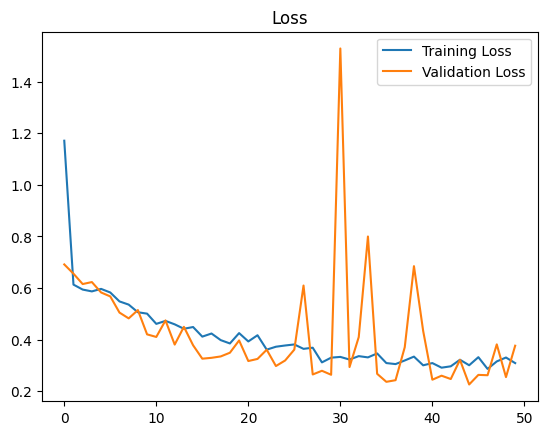

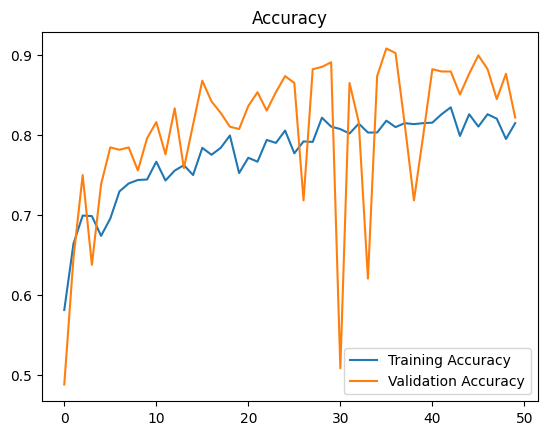

In [26]:
plot_metrics(history)

In [27]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7606 - loss: 0.5532
Test Accuracy: 79.54%
Test loss: 46.14%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


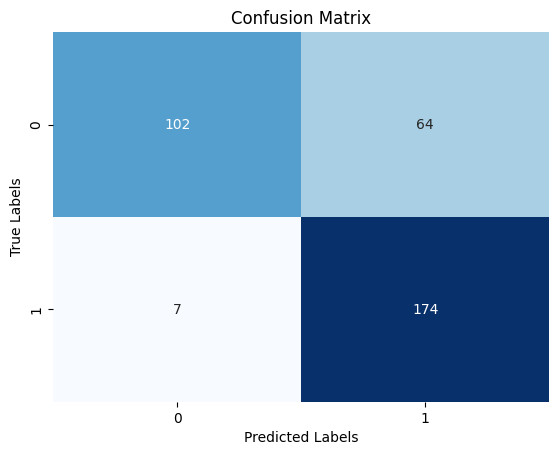

In [28]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


6. Second CNN Model

In [29]:


model2 = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
# The input shape should match your training data (X_train.shape[1:])
model2.add(Conv2D(filters=16,kernel_size=9, padding='same', activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.45))

model2.add(Conv2D(filters=16,kernel_size=9,padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.25))

model2.add(Conv2D(filters=36, kernel_size=9, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.15))


model2.add(Dense(1, activation='sigmoid'))

# Take a look at the model summary
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 16)        │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 16)        │          20,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 36)          │          46,692 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 36)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 28224)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      14,451,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,523,061 (55.40 MB)

 Trainable params: 14,523,061 (55.40 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model2.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

In [31]:
model2.fit(X_train,y_train,batch_size=128, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - acc: 0.5072 - loss: 1.1593 - val_acc: 0.4885 - val_loss: 0.6933
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 313ms/step - acc: 0.5408 - loss: 0.6926 - val_acc: 0.4885 - val_loss: 0.6935
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - acc: 0.5613 - loss: 0.6916 - val_acc: 0.4885 - val_loss: 0.6939
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - acc: 0.5495 - loss: 0.6912 - val_acc: 0.4885 - val_loss: 0.6943
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - acc: 0.5659 - loss: 0.6895 - val_acc: 0.4885 - val_loss: 0.6950
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - acc: 0.5369 - loss: 0.6910 - val_acc: 0.4885 - val_loss: 0.6954
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - acc: 0.5203 - loss: 0.6922 - val_acc: 0.4885 - val_loss: 0.6961
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - acc: 0.5409 - loss: 0.6902 - val_acc: 0.4885 - val_loss: 0.6968
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - acc

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step


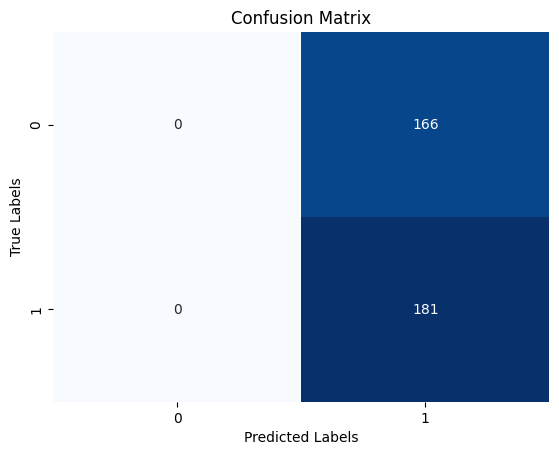

In [32]:
y_pred = model2.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [33]:
score = model2.evaluate(X_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])
print('\n', 'Test loss:', score[0])


 Test accuracy: 0.5216138362884521

 Test loss: 0.6936798691749573
